# CHEM 101.6 Project1

This is a Jupyter notebook for running and analyzing a Molecular Dynamics (MD) simulations of Butane using the OpenMM engine 


# **Setting the environment for MD calculation**

Firstly, we need to install all necessary libraries and packages for our simulation. The main packages we will be installing are:

1.    OpenMM (https://openmm.org/)
2.    PyTraj (https://amber-md.github.io/pytraj/latest/index.html)
4.    Numpy (https://numpy.org/)
5.    Matplotlib (https://matplotlib.org/)
8.    AmberTools (https://ambermd.org/AmberTools.php)

Load libraries in conda enviroment:

conda install -c conda-forge openmm 

conda install -c conda-forge jupyterlab

conda install -c conda-forge mdtraj




In [1]:
import numpy as np
import platform
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import sys
import openmm as mm
from openmm import app
from openmm import unit
from openmm import *
from openmm.app import *
from openmm.unit import *
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import scipy.stats as stats
import pandas as pd
from statistics import mean, stdev
from matplotlib import colors
import mdtraj as md
#import seaborn as sb


In [3]:
workdir='/Users/paulrobustelli/Desktop/Chem101_S24/Exercise1/'
datadir='/Users/paulrobustelli/Desktop/Chem101_S24/Exercise1/data/'
outdir='/Users/paulrobustelli/Desktop/Chem101_S24/Exercise1/outdir/'
PDB_file_name = datadir+'butane.pdb'
forcefield_file_name = datadir+'butane.gaff2.xml'

#if not os.path.exists(workDir):
#    os.makedirs(workDir)
    
print(PDB_file_name)
print(forcefield_file_name)

pdb = mm.app.PDBFile(PDB_file_name)
forcefield = mm.app.ForceField(forcefield_file_name)

system = forcefield.createSystem(pdb.topology, nonbondedMethod=mm.app.NoCutoff, constraints=mm.app.HBonds)
integrator = mm.LangevinIntegrator(298.15*kelvin, 5.0/picosecond, 2.0*femtoseconds)
integrator.setConstraintTolerance(1e-5)
platform = mm.Platform.getPlatformByName('Reference')
simulation = app.Simulation(pdb.topology, system, integrator, platform)
simulation.context.setPositions(pdb.positions)

/Users/paulrobustelli/Desktop/Chem101_S24/Exercise1/data/butane.pdb
/Users/paulrobustelli/Desktop/Chem101_S24/Exercise1/data/butane.gaff2.xml


In [4]:
print('Minimizing...')

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy before minimization is {st.getPotentialEnergy()}")

simulation.minimizeEnergy(maxIterations=100)

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy after minimization is {st.getPotentialEnergy()}")

Minimizing...
Potential energy before minimization is 5.797528692127867 kJ/mol
Potential energy after minimization is 5.295271861905613 kJ/mol


In [5]:
from sys import stdout

print('Equilibrating...')

simulation.reporters.append(app.StateDataReporter(stdout, 1000, step=True, 
    potentialEnergy=True, temperature=True, separator=','))
simulation.context.setVelocitiesToTemperature(150.0*kelvin)
simulation.step(2500)

Equilibrating...
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
1000,31.828213855217424,412.27449014031674
2000,54.38930340036396,504.85980445083766


In [6]:
os.path.join(workdir, "butane_sim.dcd")

'/Users/paulrobustelli/Desktop/Chem101_S24/Exercise1/butane_sim.dcd'

In [7]:
import time as time

print('Running Production...')

# Begin timer
tinit=time.time()

# Clear simulation reporters
simulation.reporters.clear()

# Reinitialize simulation reporters. We do this because we want different information printed from the production run than the equilibration run.
# output basic simulation information below every 250000 steps - (which is equal to 2 fs(250,000) = 500,000 fs = 500 ps)
simulation.reporters.append(app.StateDataReporter(stdout, 250000, 
    step=True, time=True, potentialEnergy=True, temperature=True, 
    speed=True, separator=','))

# write out a trajectory (i.e., coordinates vs. time) to a DCD
# file every 100 steps - 0.2 ps
simulation.reporters.append(app.DCDReporter(os.path.join(workdir, "butane_sim.dcd"),100))
                
# run the simulation for 1.0x10^7 steps - 20 ns
simulation.step(10000000)

# End timer
tfinal=time.time()
print('Done!')
print('Time required for simulation:', tfinal-tinit, 'seconds')

Running Production...
#"Step","Time (ps)","Potential Energy (kJ/mole)","Temperature (K)","Speed (ns/day)"
250000,500.0000000016593,39.127581291749394,251.301331601811,0
500000,999.9999999901769,30.09962513012026,351.2177091008982,3.45e+04
750000,1499.9999999783536,33.092464390708514,393.33081319749147,3.46e+04
1000000,1999.9999999665301,33.91905800421554,268.0437686149411,3.45e+04
1250000,2499.9999999547067,39.143224793185496,231.052112617756,3.44e+04
1500000,2999.9999999428833,47.609922936022706,249.66907962725517,3.42e+04
1750000,3499.99999993106,49.92082847895796,331.36410891630493,3.42e+04
2000000,3999.9999999192364,33.570426545314206,252.0668324277568,3.41e+04
2250000,4499.9999999992715,34.26920728392356,232.7822018878875,3.4e+04
2500000,5000.000000101135,46.31014556623579,423.92884394412175,3.4e+04
2750000,5500.000000202998,26.00555131840074,199.7924078229314,3.4e+04
3000000,6000.000000304862,53.35546682317195,265.4205375600757,3.4e+04
3250000,6500.000000406725,61.031467248097414

In [15]:
import mdtraj as md
traj = md.load(os.path.join(workdir, "butane_sim.dcd"), top=PDB_file_name)
traj


<mdtraj.Trajectory with 100000 frames, 14 atoms, 1 residues, without unitcells at 0x13f5681d0>

In [16]:
atoms, bonds = traj.topology.to_dataframe()
atoms

,serial,name,element,resSeq,resName,chainID,segmentID
0,1,C1,C,1,NBU,0,
1,2,H11,H,1,NBU,0,
2,3,H12,H,1,NBU,0,
3,4,H13,H,1,NBU,0,
4,5,C2,C,1,NBU,0,
5,6,H21,H,1,NBU,0,
6,7,H22,H,1,NBU,0,
7,8,C3,C,1,NBU,0,
8,9,H31,H,1,NBU,0,
9,10,H32,H,1,NBU,0,


In [17]:
#Lets select the topology
top=traj.topology
top

<mdtraj.Topology with 1 chains, 1 residues, 14 atoms, 13 bonds at 0x13f5ca3d0>

In [18]:
#Select All Carbon Atoms
C_sel=top.select("type C")
print(C_sel)
#Confirm that we have selected what we think we have
for atom in C_sel:
    print(top.atom(atom))

[ 0  4  7 10]
NBU1-C1
NBU1-C2
NBU1-C3
NBU1-C4


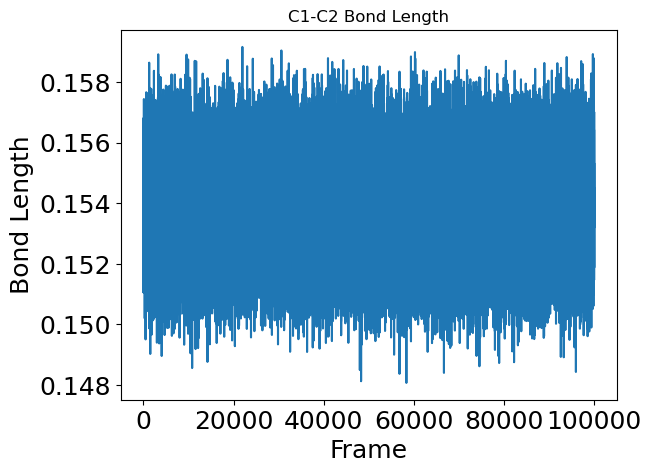

In [19]:
#Compute Some Distances and plot the time course
bond_indices = [0, 4] 
C1C2bondlength = md.compute_distances(traj, [bond_indices])
plt.plot(C1C2bondlength)
plt.xlabel('Frame', size=18)
plt.xticks(size=18)
plt.yticks(size=18)
plt.ylabel('Bond Length', size=18)
plt.title('C1-C2 Bond Length')
plt.show()

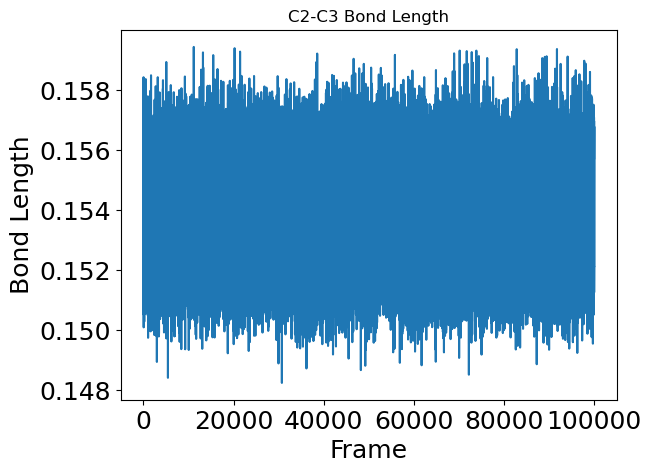

In [20]:
bond_indices = [4, 7] 
C2C3bondlength = md.compute_distances(traj, [bond_indices])
plt.plot(C2C3bondlength)
plt.xlabel('Frame', size=18)
plt.xticks(size=18)
plt.yticks(size=18)
plt.ylabel('Bond Length', size=18)
plt.title('C2-C3 Bond Length')
plt.show()

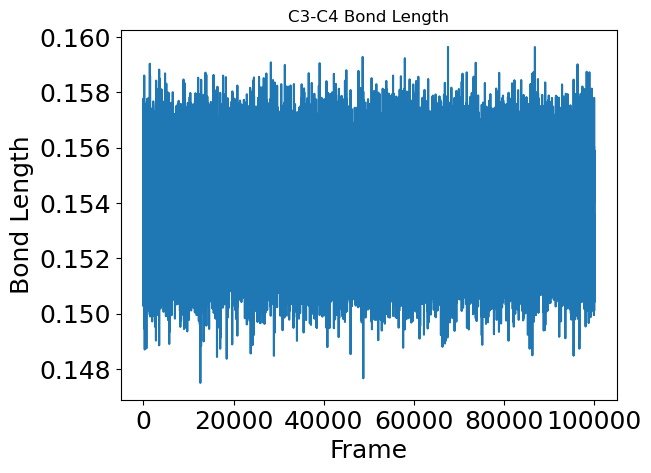

In [21]:
bond_indices = [7, 10] 
C3C4bondlength = md.compute_distances(traj, [bond_indices])
plt.plot(C3C4bondlength)
plt.xlabel('Frame', size=18)
plt.xticks(size=18)
plt.yticks(size=18)
plt.ylabel('Bond Length', size=18)
plt.title('C3-C4 Bond Length')
plt.show()

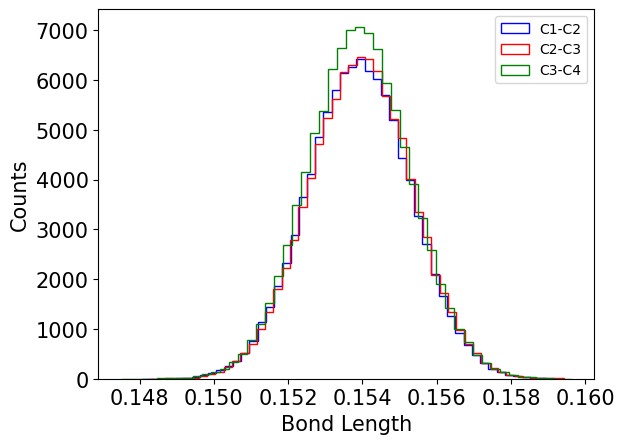

In [22]:
#https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
plt.hist(C1C2bondlength,label='C1-C2',color='b',histtype='step',bins=50)
plt.hist(C2C3bondlength,label='C2-C3',color='r',histtype='step',bins=50)
plt.hist(C3C4bondlength,label='C3-C4',color='g',histtype='step',bins=50)
plt.legend(loc='upper right')
plt.xlabel('Bond Length', size=15)
plt.xticks(size=15)
plt.ylabel('Counts', size=15)
plt.yticks(size=15)
plt.show()

Lets Write Functions to Calculate the Variance ($\sigma^2$) and Standard Deviation ($\sigma$)

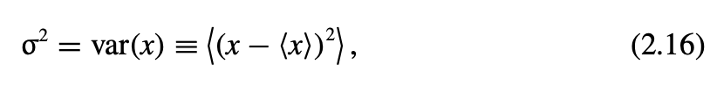

In [687]:
######Class Activtiy: Calculate the Variance and Standard Deviation of Each Bond Length######


In [23]:
###SOLUTION###


In [24]:
#Lets Check Our Answers with the Built In Numpy Libraries
print("C1-C2 average:",np.average(C1C2bondlength),"variance:",np.var(C1C2bondlength),"std-dev:",np.std(C1C2bondlength))
print("C2-C3 average:",np.average(C2C3bondlength),"variance:",np.var(C2C3bondlength),"std-dev:",np.std(C2C3bondlength))
print("C3-C4 average:",np.average(C3C4bondlength),"variance:",np.var(C3C4bondlength),"std-dev:",np.std(C3C4bondlength))

C1-C2 average: 0.15390237 variance: 1.8896328e-06 std-dev: 0.0013746391
C2-C3 average: 0.15395042 variance: 1.9033658e-06 std-dev: 0.0013796253
C3-C4 average: 0.1539007 variance: 1.8830835e-06 std-dev: 0.0013722549


***Class Activity: Lets Check if These Bond Lengths Are Correlated and Calculate the Coerrleation Coefficents***

***First Calculate a Best Fit Line****

We can do this using the np.polyfit function:

https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html

***Now Calculate the Perason Correlation Coefficient***
We can use numpy to calculate the correlation coeffient 

https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html

This function works for n-arrays, so it will report correlation coefficient matrix, and we need to select our coefficient of interest, which in our case is the off diagnol  


Line Parameters: [0.50013428 0.07697493]


/var/folders/b8/wkchz8t96zs728n_c4s7mpxh0000gn/T/ipykernel_53872/1769237437.py:9: RankWarning: Polyfit may be poorly conditioned
  line_fit=np.polyfit(C1C2bondlength[:,0],C2C3bondlength[:,0],1)


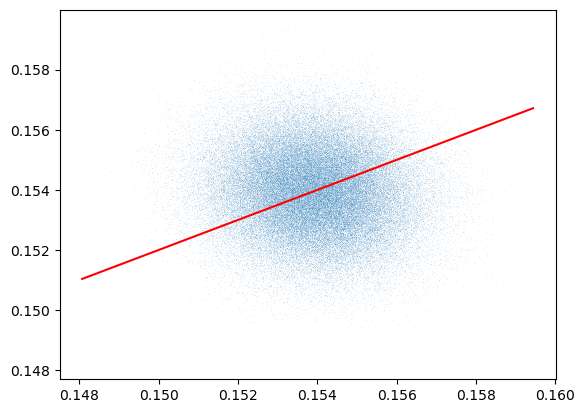

r2: -0.09129045878332458
Line Parameters: [0.4999746  0.07695035]


/var/folders/b8/wkchz8t96zs728n_c4s7mpxh0000gn/T/ipykernel_53872/1769237437.py:22: RankWarning: Polyfit may be poorly conditioned
  line_fit=np.polyfit(C1C2bondlength[:,0],C3C4bondlength[:,0],1)


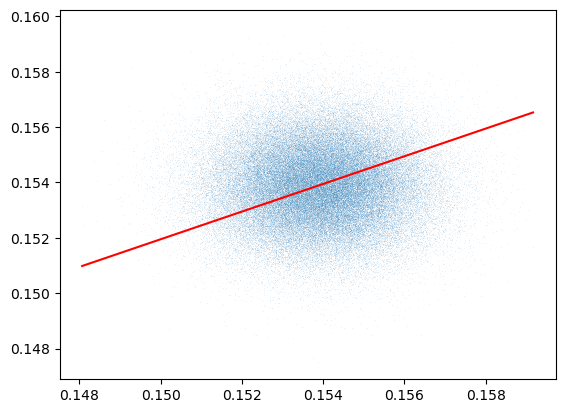

r2: 0.0027398199080115072


In [25]:
#####Are these bond lengths correlated?##### 
###Calculate and plot a best fit line, and calculate the correlation coefficient####

plt.scatter(C1C2bondlength,C2C3bondlength,marker='x',s=0.1,linewidth=0.05)

#######SOLUTION###########


line_fit=np.polyfit(C1C2bondlength[:,0],C2C3bondlength[:,0],1)
x = np.linspace(min(C1C2bondlength[:,0]), max(C2C3bondlength[:,0]),20)
y = line_fit[0]*x+line_fit[1]
print("Line Parameters:",line_fit)
plt.plot(x,y,c='r',label='best fit line')
plt.show()
plt.clf()

r=np.corrcoef(C1C2bondlength[:,0], C2C3bondlength[:,0])
print("r2:",r[0,1])

plt.scatter(C1C2bondlength,C3C4bondlength,marker='x',s=0.1,linewidth=0.05)

line_fit=np.polyfit(C1C2bondlength[:,0],C3C4bondlength[:,0],1)
x = np.linspace(min(C1C2bondlength[:,0]), max(C1C2bondlength[:,0]),20)
y = line_fit[0]*x+line_fit[1]
print("Line Parameters:",line_fit)
plt.plot(x,y,c='r',label='best fit line')
plt.show()

r=np.corrcoef(C1C2bondlength[:,0], C3C4bondlength[:,0])
print("r2:",r[0,1])

**WEEK 1 Homework Question:  Why does one pair of these bonds appear slightly more correlated than the other?**

***Class Activity*** 

***Lets write a function to calculate the histogram, return the density and centers
and fit a guassian to each of these distributions?***

Lets Turn these histograms into a probability densities and then fit them to a
normal (Gaussian) Distribution

https://numpy.org/doc/stable/reference/generated/numpy.histogram.html
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

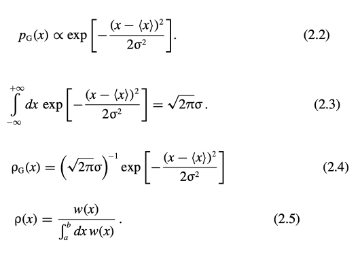
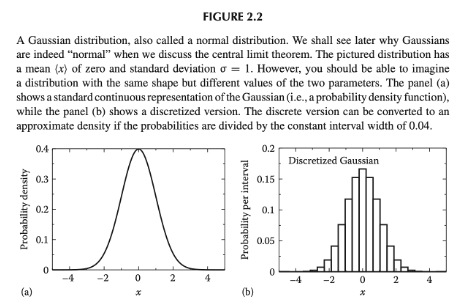

a: 0.18614742386222055 x0: 0.15390436696837315 fit_sigma: -0.0013950701832143493


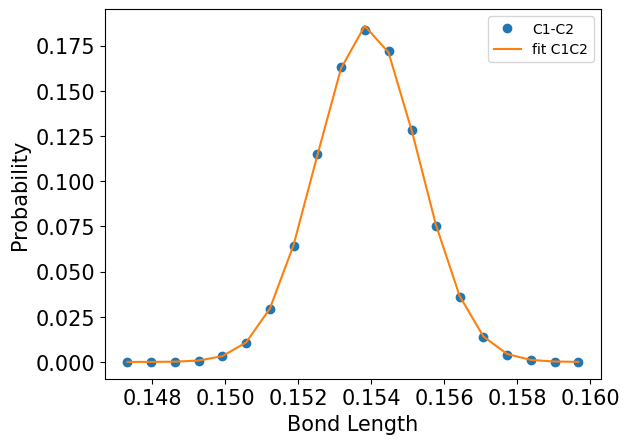

In [27]:
#Lets calculate a Probability Density and fit a gaussian to these
#First lets pull out the data in a formate we can fit
#https://numpy.org/doc/stable/reference/generated/numpy.histogram.html
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

from scipy.optimize import curve_fit

####SOLUTION####

#First we convery our histogram into bin centers and probabilities
#isntead of bin edges and counts:

### THIS IS WHAT YOU WANT TO TURN INTO A FUNCTION FOR HOMEWORK ####
counts, edges = np.histogram(C1C2bondlength, bins=20, range=[0.147,0.160])
centers = edges[:-1] + np.diff(edges)/2
density=counts/np.sum(counts)

###Now we define a gaussian function that we'll fit to our probability densities

def gauss(x, a, x0, sigma):
    return (a*np.exp(-(x-x0)**2/(2*sigma**2)))

#### Now we define a function to fit the gaussian with curve fit

def fit_gauss(x,y):
    parameters, covariance = curve_fit(gauss, x, y)
    fit_a = parameters[0]
    fit_x0 = parameters[1]
    fit_sigma = parameters[2]
    print("a:",fit_a,"x0:",fit_x0,"fit_sigma:",fit_sigma)
    fit_y = gauss(centers, fit_a, fit_x0,fit_sigma)
    return fit_y,[fit_a,fit_x0,fit_sigma] 

#C1C2_density,centers=histogram_bincenters(C1C2bondlength,0.147,0.160,20)
C1C2_fit,C1C2_fit_params=fit_gauss(centers,density)

plt.plot(centers, density, 'o', label='C1-C2')
plt.plot(centers, C1C2_fit, '-', label='fit C1C2')


plt.legend()
plt.xlabel('Bond Length', size=15)
plt.xticks(size=15)
plt.ylabel('Probability', size=15)
plt.yticks(size=15)
plt.show()


***Homework Porblem 1:  Can you write a function to calculate the histogram, return the density and centers
and fit a guassian to each of these distributions?***

In [48]:
#Can you write a function to calculate the histogram, return the density and centers,
#and then fit a guassian to each of these distributions? 

####HOMEWORK SOLUTION####


**Week 1 Homework Problem #2: convert these probability distributions to culmulative distribution functions**

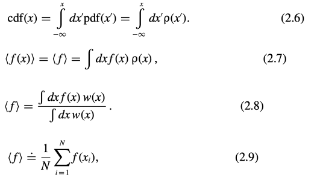

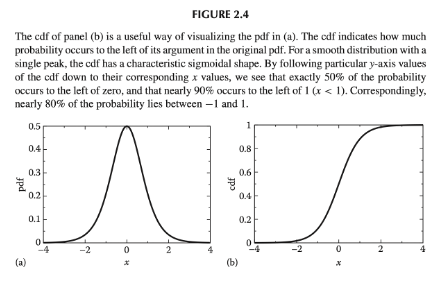

In [29]:
###WEEK 1 HOMEWORK#### 

####HOMEWORK SOLUTION####


#ADD CODE FOR CDFs HERE#


**WEEK 1 Homework Problem #3: Lets draw some random frames from our trajectory (for example 10,100,1000,10000),  calculate the probability distribution functions for 4 of these random samples, and fit  gaussians to these probability distirbution functions for 1) A Bond Angle 3) A Dihedral Angle ***
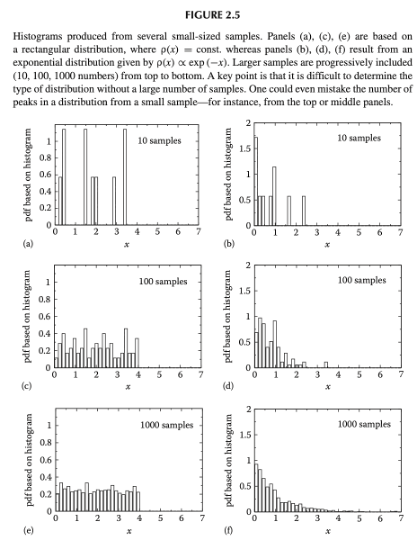

In [30]:
#ADD CODE FOR FITTING GUASSIAN FUNCTIONS TO RANDOM SAMPLES  HERE#
#Draw 10,100,1000 random samples of a bond angle - FIT THEM TO BOND ANGLE

#This function might be helpful:
rands=np.random.randint(10000, size=(10))
rands

#Draw 10,100,1000,10000 random samples of a dihedral angle - FIT THEM TO A GAUSSIAN - WHY IS THIS FIT SO POOR?


array([8921, 2873, 8241, 3225, 3149, 4985, 3163, 6998,  730, 3292])

**Class Activity: Lets Compute the 2 C-C-C Bond Anlges and C-C-C-C Dihedral Angle ***

Plot their time course and their histograms.  Find a nice way to visualize the C-C-C-C dihedral angle 

In [38]:
###Class Room Solution###
##Lets Compute Some Bond Angles & Torsions##
Angle1=[0,4,7]
Angle2=[4,7,10]

ang = md.compute_angles(traj,[Angle1,Angle2])c
ang1=ang[:,0]
ang1
#CCCC_torsion=md.compute_dihedrals(traj, [CCCC_index])



array([1.9515724, 1.8890599, 1.9106187, ..., 1.9475055, 1.9642272,
       1.9984161], dtype=float32)

***Week 1 Homework Question:  What is the probability of being found in the higher free energy C-C-C-C dihedral state?*****

In [51]:
####Week 1 Homework Question: What is the probability of being found in the higher free energy C-C-C-C dihedral state?####

#### Calculate Here #####


**Class Activity: Are The Bond Angles and Dihedral Angle Correlated?**

In [34]:
#### COMPLETE IN-CLASS ACTIVITY HERE #####
#Are the bond angle and dihedral correlated?



##### ADD FANCY SEABORN PLOT HERE ######

**Homework Problem 3: Can you express the relationsip between these two quantites using histograms and conditional probabilities ?** 

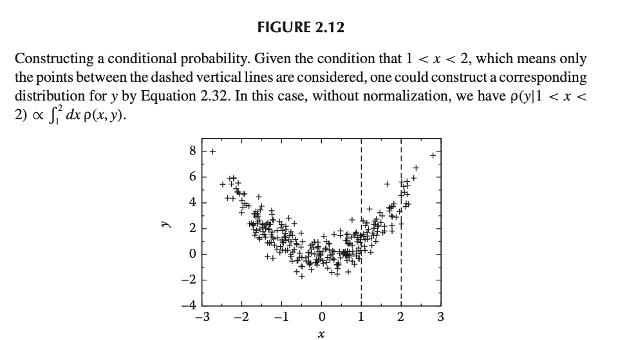

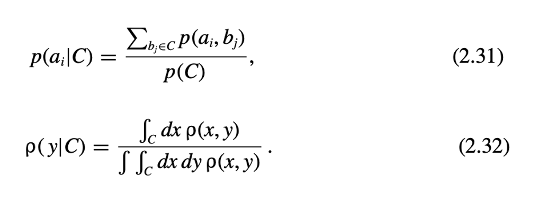

In [ ]:
#Homework problem 3 Solution ##

#### THis will require the use of np.where() 
###https://numpy.org/doc/stable/reference/generated/numpy.where.html
CCCC_dihe
a=np.where(CCCC_dihe<0)
print(a)
CCCC_dihe[a]
b=np.where(CCCC_dihe>-2)
print(b)
CCCC_dihe[b]
c=np.where((CCCC_dihe<0) & (CCCC_dihe>-2))
print(c)
CCCC_dihe[c]

In [52]:
#Will Walk through example of Autocorrelation Function (ACF) calculation here#
def autocorr1(x,lags):
    '''numpy.corrcoef, partial'''
    corr=[1. if l==0 else numpy.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return numpy.array(corr)
    
print(ang1)
print(ang1[1:])
print(ang1[:-1])

[1.9515724 1.8890599 1.9106187 ... 1.9475055 1.9642272 1.9984161]
[1.8890599 1.9106187 1.9444959 ... 1.9475055 1.9642272 1.9984161]
[1.9515724 1.8890599 1.9106187 ... 1.8702377 1.9475055 1.9642272]


**Class Activity: Lets Calculate the Autocorrelation Times of C-C Bonds, C-C-C Angles, and C-C-C-C Dihedrals**

https://ipython-books.github.io/103-computing-the-autocorrelation-of-a-time-series/

[0.00000e+00 2.00002e-01 4.00004e-01 ... 1.99996e+04 1.99998e+04
 2.00000e+04]


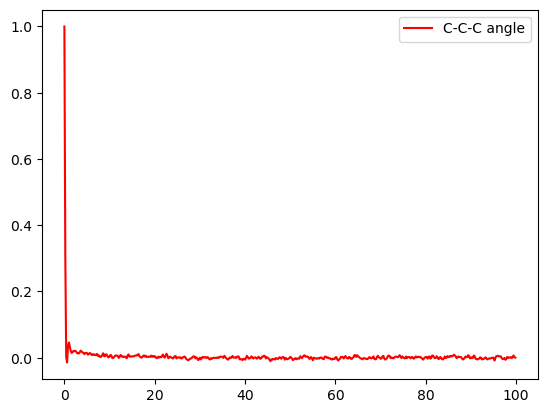

In [41]:
#Lets Calculate the autocorrelation times for bond lengths, bond angles, and torsions:
def autocorr1(x,lags):
    '''numpy.corrcoef, partial'''
    corr=[1. if l==0 else numpy.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return numpy.array(corr)

#time in picoseconds
time=np.linspace(0,20000,traj.n_frames)
print(time)

lags=range(500)
#C1C2bondlength[:,0]
#bond_autocor=autocorr1(C1C2bondlength[:,0],lags)
ang_autocor=autocorr1(ang1,lags)
#dihe_autocor=autocorr1(np.cos(CCCC_torsion[:,0]),lags)
#plt.plot(time[lags],bond_autocor,color='b',label='C-C bond')
plt.plot(time[lags],ang_autocor,color='r',label='C-C-C angle')
#plt.plot(time[lags],dihe_autocor,color='g',label='C-C-C-C dihedral')
plt.legend()

**Class Activity: Lets Dig Into force field XML file and make plots of the force field torsion terms**

Documentation of Torsion Term Conventions:

https://ambermd.org/doc12/Amber21.pdf#page=264

http://docs.openmm.org/latest/userguide/application/05_creating_ffs.html#basic-concepts

From Butane.gaff2.xml

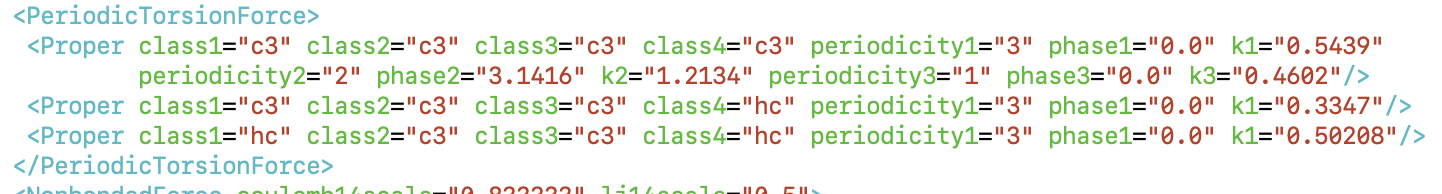

In [45]:
#Plot The Torsion Force Field Terms

#First Lets make a linespace from -pi to pi
rad_ang=np.linspace(0,2*math.pi,30)

##Lets write a function to plot the values of force field terms


In [46]:
##Lets Review all our atoms as we attempt to tabulate all the relevant torsion terms
atoms, bonds = traj.topology.to_dataframe()
atoms

,serial,name,element,resSeq,resName,chainID,segmentID
0,1,C1,C,1,NBU,0,
1,2,H11,H,1,NBU,0,
2,3,H12,H,1,NBU,0,
3,4,H13,H,1,NBU,0,
4,5,C2,C,1,NBU,0,
5,6,H21,H,1,NBU,0,
6,7,H22,H,1,NBU,0,
7,8,C3,C,1,NBU,0,
8,9,H31,H,1,NBU,0,
9,10,H32,H,1,NBU,0,


 <PeriodicTorsionForce>
  <Proper class1="c3" class2="c3" class3="c3" class4="c3" periodicity1="3" phase1="0.0" k1="0.5439" 
          periodicity2="2" phase2="3.1416" k2="1.2134" periodicity3="1" phase3="0.0" k3="0.4602"/>
  <Proper class1="c3" class2="c3" class3="c3" class4="hc" periodicity1="3" phase1="0.0" k1="0.3347"/>
  <Proper class1="hc" class2="c3" class3="c3" class4="hc" periodicity1="3" phase1="0.0" k1="0.50208"/>

 <PeriodicTorsionForce>
  <Proper class1="c3" class2="c3" class3="c3" class4="c3" periodicity1="3" phase1="0.0" k1="0.5439" 
          periodicity2="2" phase2="3.1416" k2="1.2134" periodicity3="1" phase3="0.0" k3="0.4602"/>
  <Proper class1="c3" class2="c3" class3="c3" class4="hc" periodicity1="3" phase1="0.0" k1="0.3347"/>
  <Proper class1="hc" class2="c3" class3="c3" class4="hc" periodicity1="3" phase1="0.0" k1="0.50208"/>

In [781]:
#Lets Tally Up All The Torsions Along the Central Carbon
#Atomnames: (H41,H42,H43)-C4-C3(H31,H32)-C2(H21,H22)-C1(H11,H12,H13)
#Atomnumbers: (13,12,11)-10-(8,9)7-4(5,6)-0(1,2,3)


**Homework Problem #5: Many of These Correlations will be highly Correlated Select Some Torsions that are Correlated, and some that are not, and make scatter plots of their relationships**

For a Torsion Angle Pair that is highly correlated, can you find a relatively constant offset?  

For a Torsion Angle Pair that are less correlated, how can you interpret their scatter plots?

In [53]:
####WEEK 1 STOP HERE######

In [1]:

####WEEK 2 Homework Problem 5 - Correlations in torsion paramters###
#PLOT SOME TORSIONS THAT YOU EXPECT TO BE HIGHLY CORRELATED - EXPLAIN WHY - EXPLAIN WHAT OU SEE
#Consider CCCC vs. [8,7,4,5]


#PLOT SOME TORSIONS THAT YOU EXPECT TO BE UNCORRELATED - Explain what you see
#Consider CCCC vs. [12,10,7,9]


In [2]:
#SELECT TWO TORSIONS THAT YOU EXPECT TO HAVE A SYSTEMATIC OFFSET 
#CALCULATE THEIR OFFSET IN EACH FRAME - EXPLAIN YOUR RESULT
#plt.scatter(CCCC_torsion,HCCH_torsions[:,1],marker='x',linewidth=0.04)
#diff=CCCC_torsion[:,0]-HCCH_torsions[:,3]


***WEEK 2 Homework Problem #2: Lets modify the C-C-C-C Torsion Potential to change the dihedral distribution***


Lets try to lower the dihedral barriers for torsion angles of 1 radian (~60 degrees)
This means we need to to come up with a torsion potential, potentially by using multiple terms with different phases, to equalize the free energy of each C-C-C-C torsion basin (increasing the free energy at $\pi$ and lowering 
free energy at $\pi$/3

Once you've come up with torsion terms you're happy with, you'll need to make a copy of the butane.gaff2.xml, add in the additional torsion terms you have come up with, and run a new simulation.  Then plot the C-C-C-C dihedral histogram or PMF, and compare it to the simulation with original force field.

It would be great if you came up with some kind of fitting routine to determine the coefficients of torsions, perhaps by targeting a gaussian, or you can try to arrive at by hand using something like this:

https://www.desmos.com/calculator/ea1qhzjnuf

In [4]:
###SOLUTION#####



***WEEK 2 Homework Problem #2 Attempt to run a new MD Simulation with your modified torsion potential***

Once you have made a torsion correction you like make a new force field file 'butane.gaff2.cor1.xml'.

Run a new simulation with this force field and compare the dihedral distributions 

In [ ]:
#RUN NEW MD SIMULATION HERE#

In [54]:
#Compare New Dihedral Distribution HERE)

**WEEK 2 Homework Problem #3 Plot the LJ and Coulumb Forcefield Potentials for 3 types of atom pairs**

#CHECK THE COMBINATION RULES USED FOR OPENMM##


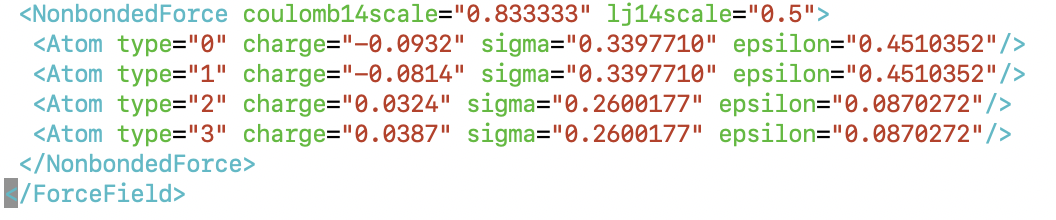




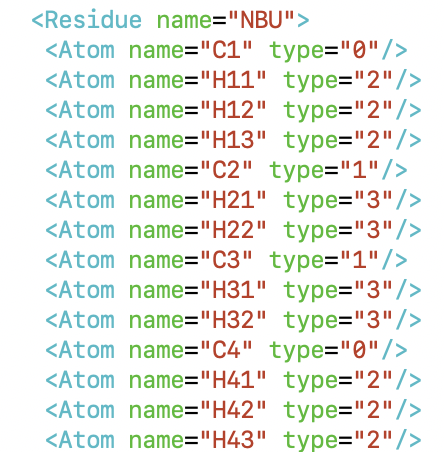

In [ ]:
#Plot LJ and Couloumb Potentionals Here